# Maps & Plotting with GeoPandas, Contelity Base Tiles, Image read in by matplotlib, point overlays. Including labeling, legend displays, and subplot methods.

### We are using basemap tiles. but you can also use a background geolocated image from open street map or the matplotlib Basemap library

### For more background and context, please see other notebooks detailing the ETL, graph route analysis, and exploration used here.

#### INSTALL THIS CONTEXTILY PACKAGE WITHIN YOU NOTEBOOK THIS WAY TO ENSURE ANACONDA CAN USE IT AND CORRECT LOCATION


In [1]:
#!pip install contextily

In [1]:
import json
import requests
import pandas as pd
import numpy as np
import geopandas as gpd 
import geopandas
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

%matplotlib inline

# Start here! since the data has already been conditioned in the ETL notebook

### FYI New York city coordinates are (https://www.travelmath.com/cities/New+York,+NY):

    longitude = -74.0063889
    lattitude = 40.7141667

### Then Read in the Pizza Essentials file and Manhattan Distance TSP Solution 


In [2]:
#  MUST IMPORT THE SHAPEFILE !
points = geopandas.read_file("../shapefiles/pizzaTSPgeopandas.shp")

In [4]:
#import fiona; help(fiona.open)

In [5]:
#import fiona; fiona.supported_drivers

## Setting the CRS and changing the projection type. Yes you have to do this every import. Or at least check, but the import with crs isn't reliable
###  https://stackoverflow.com/questions/38961816/geopandas-set-crs-on-points


### TRANSFORM CRS
#### WGS84 is 4326   
#### Mercator is 3857
### Set up geodataframe, initially with CRS = WGS84 (since that matches the long and lat co-ordinates)


In [3]:
points.crs = {'init': 'epsg:4326'}
print(points.crs)
# project to merkator
points = points.to_crs("EPSG:3857")
#points.to_crs("EPSG:3857")
print(points.crs)


+init=epsg:4326 +type=crs
EPSG:3857


/Users/RoscoeBColtrane/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Adding a background map to plots
https://geopandas.readthedocs.io/en/latest/gallery/plotting_basemap_background.html#sphx-glr-gallery-plotting-basemap-background-py

#### Convert the data to Web Mercator

Web map tiles are typically provided in Web Mercator (EPSG 3857), so we need to make sure to convert our data first to the same CRS to combine our polygons and background tiles in the same map:

epsg:2263


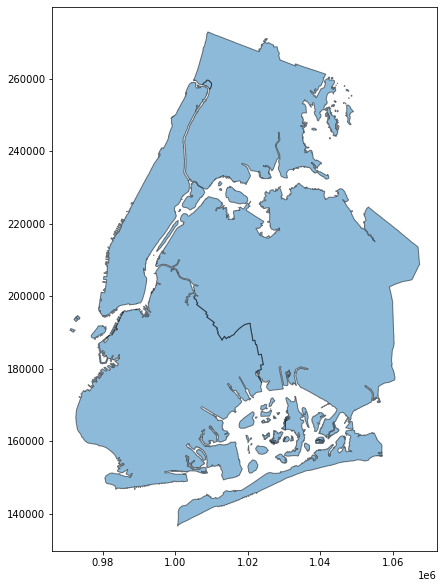

In [11]:
#  read in NYC and boroughs
dfNY = gpd.read_file(gpd.datasets.get_path('nybb'))
#ax = dfNY.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
print(dfNY.crs)

# Exclude Staten Island for now
# ### if needed ####   SET AXIS BOUNDING BOX LIMITS
x0, y0, x1, y1 = dfNY.geometry.total_bounds
dfNY = dfNY[dfNY['BoroName'].isin(['Staten Island']) == False]
dfNY.plot(figsize=(20,10), alpha=0.5, edgecolor='k' )


In [83]:
dfNY = dfNY.to_crs("EPSG:3857")

/Users/RoscoeBColtrane/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


#### ZOOM IN ON THE BASIC OPEN STREET MAP UNDER LAYER
#### and experiment with basemap tiles from STAMEN   http://maps.stamen.com/#terrain/12/37.7706/-122.3782


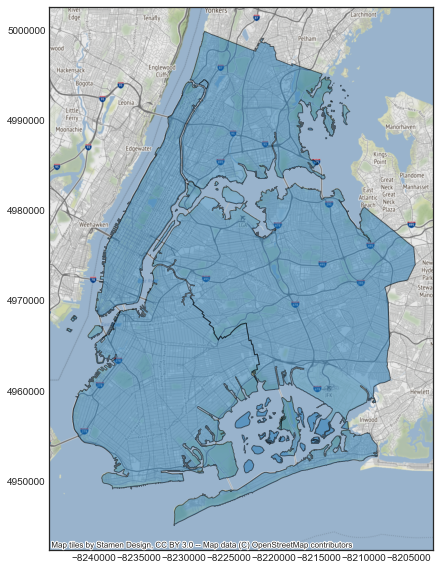

In [84]:
ax = dfNY.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, zoom=12)


/Users/RoscoeBColtrane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  


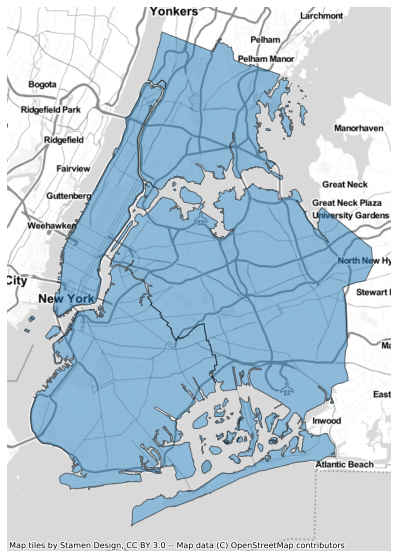

In [10]:
ax = dfNY.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

   ## Plot and Save to file
    ## Use the contextility package to pull in the basemap tile (projected in mercator 'crs = 3857'. 
    ## Overlay the TSP points, reprojected with CRS = 3857 too.
    ## Plot with title and legend

/Users/RoscoeBColtrane/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:471: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/Users/RoscoeBColtrane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1, 'NYC Pizza Essentials')

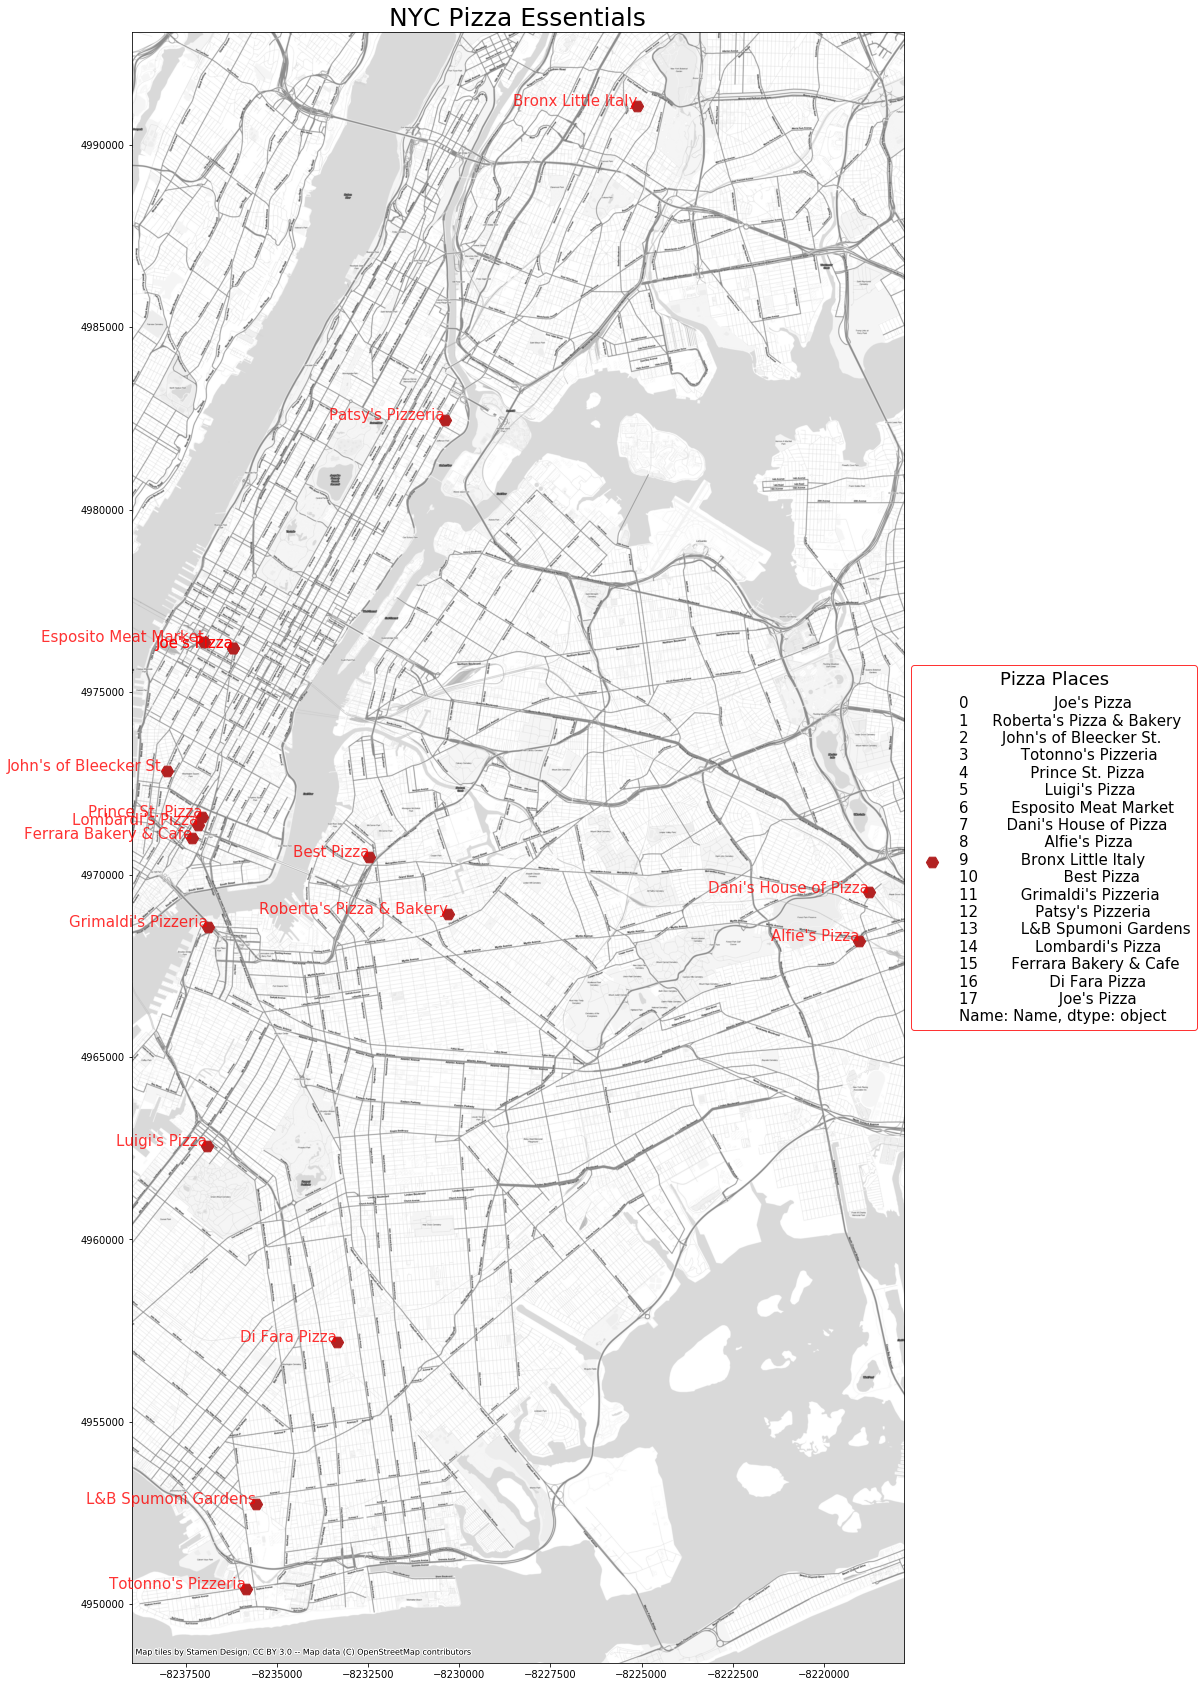

In [11]:
ax= points.plot(ax, marker= 'H', color='firebrick', markersize=150, figsize=(30,30),label=points['Name'])
points.apply(lambda x: ax.annotate(s=x.Name, xy=x.geometry.centroid.coords[0],size=15,ha='right', alpha=.8,c='red'),axis=1)
ctx.add_basemap(ax=ax,url=ctx.providers.Stamen.TonerLite, zoom=15)

# UNCOMMENT THIS LINE TO REMOVE AXES
#ax.set_axis_off()

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),title="Pizza Places", fontsize=15, title_fontsize=18,
          fancybox=True,edgecolor = 'r')
plt.title('NYC Pizza Essentials', fontsize=25)

#plt.savefig('Pizza_geopandas.png',bbox_inches='tight');


## Next we'll do a live url connection to get the background tile. This way is more tedious and harder to change the plot output

In [12]:
#  Create a python script and define the contextily helper function
def add_basemap(ax, zoom, url='http://tile.stamen.com/toner-lite/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

/Users/RoscoeBColtrane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  after removing the cwd from sys.path.
/Users/RoscoeBColtrane/anaconda3/lib/python3.7/site-packages/contextily/tile.py:268: FutureWarning: The url format using 'tileX', 'tileY', 'tileZ' as placeholders is deprecated. Please use '{x}', '{y}', '{z}' instead.
  FutureWarning,


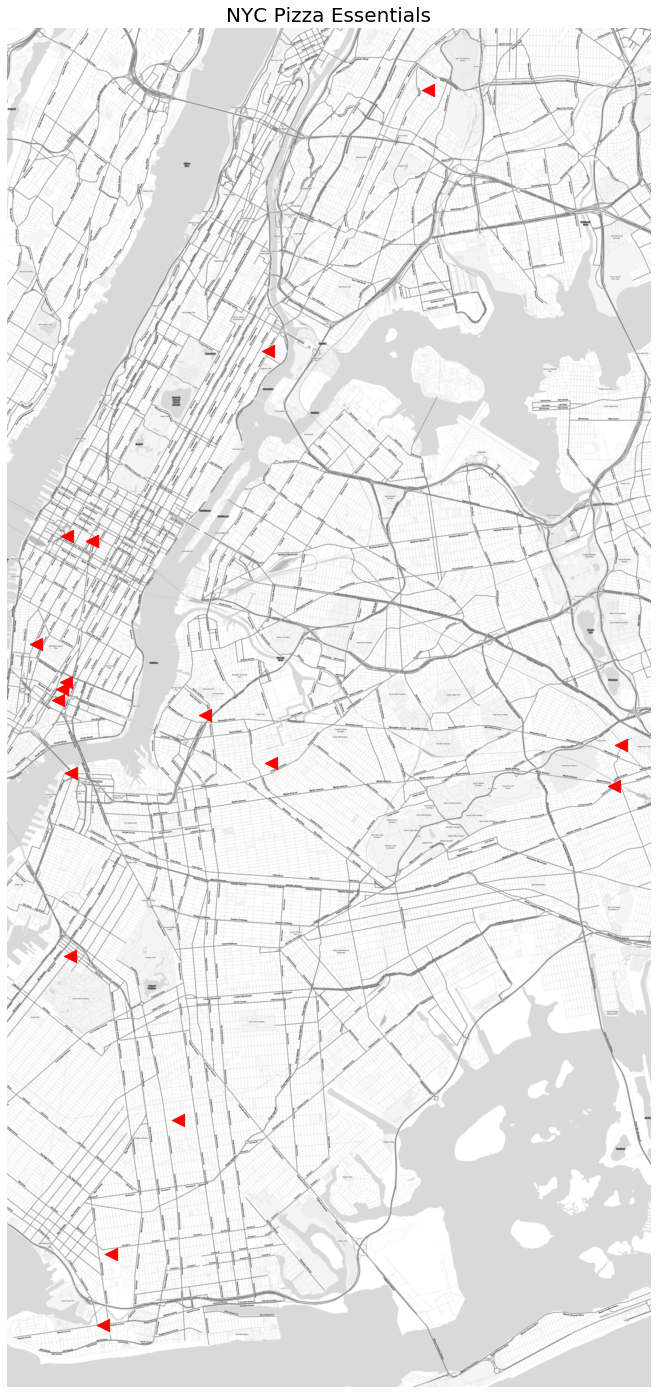

In [13]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd

# ... and make the plot
ax = points.plot(
    figsize= (30, 25),
    color='red', marker='<',markersize=150, legend=True) #alpha  = .1, 
add_basemap(ax, zoom=15)
ax.set_axis_off()

plt.title('NYC Pizza Essentials', fontsize=20)
plt.show()

#plt.savefig('Pizza_geopandas.png',bbox_inches='tight');

In [14]:
colors = dict(zip(points.ID, points.Name))
colors

{0: "Joe's Pizza",
 1: "Roberta's Pizza & Bakery",
 2: "John's of Bleecker St.",
 3: "Totonno's Pizzeria",
 4: 'Prince St. Pizza',
 5: "Luigi's Pizza",
 6: 'Esposito Meat Market',
 7: "Dani's House of Pizza",
 8: "Alfie's Pizza",
 9: 'Bronx Little Italy',
 10: 'Best Pizza',
 11: "Grimaldi's Pizzeria",
 12: "Patsy's Pizzeria",
 13: 'L&B Spumoni Gardens',
 14: "Lombardi's Pizza",
 15: 'Ferrara Bakery & Cafe',
 16: 'Di Fara Pizza',
 17: "Joe's Pizza"}

## FOR MORE CONTEXT HERE ARE THE LINKS TO MATPLOTLIB COLORS!
### https://matplotlib.org/3.1.0/gallery/color/named_colors.html
### https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

In [16]:
dfNY

BoroCode   BoroName     Shape_Leng    Shape_Area  \
1         4     Queens  896344.047763  3.045213e+09   
2         3   Brooklyn  741080.523166  1.937479e+09   
3         1  Manhattan  359299.096471  6.364715e+08   
4         2      Bronx  464392.991824  1.186925e+09   

                                            geometry  
1  MULTIPOLYGON (((-8219461.925 4952778.732, -821...  
2  MULTIPOLYGON (((-8222843.672 4950893.793, -822...  
3  MULTIPOLYGON (((-8238858.864 4965915.024, -823...  
4  MULTIPOLYGON (((-8226155.130 4982269.949, -822...

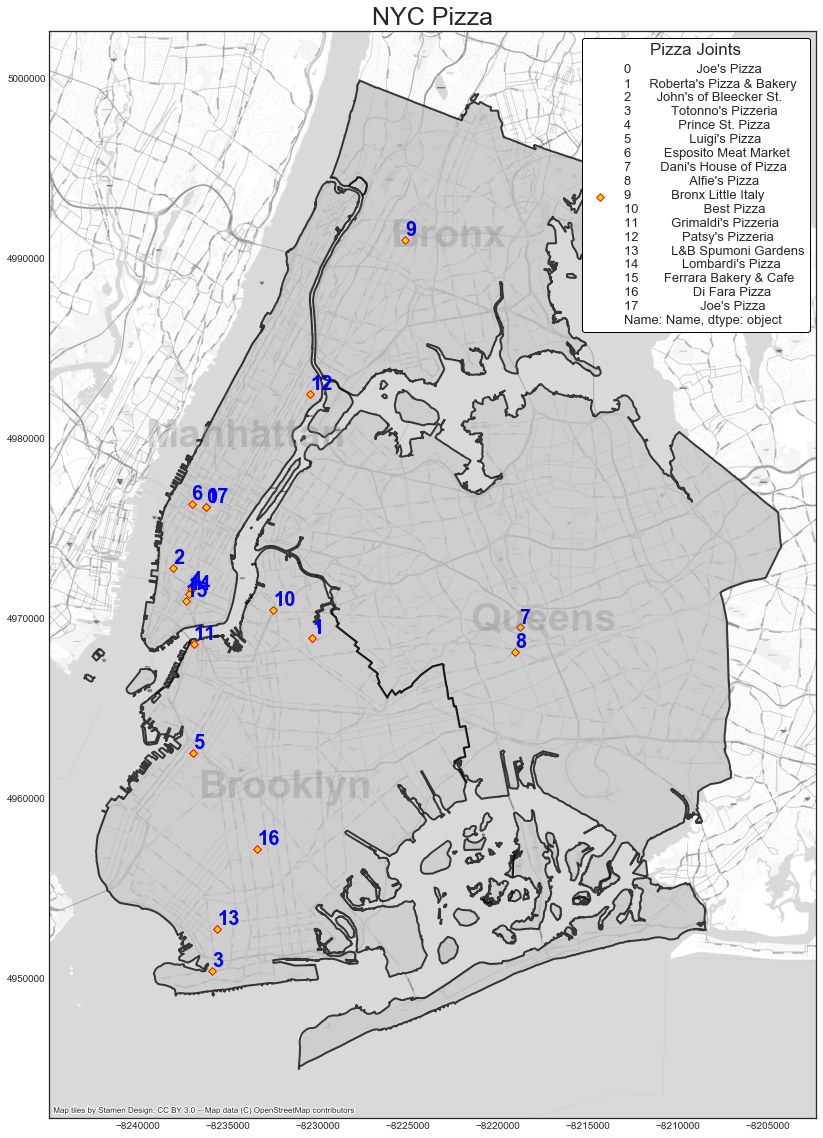

In [65]:
#plt.style.use('seaborn-white')
fig, ax = plt.subplots(figsize=(20,20))
base = dfNY.plot(ax=ax, alpha=.75, edgecolor='k', facecolor = 'silver',linewidth=2)
dfNY.apply(lambda x: ax.annotate(s=x.BoroName, xy=x.geometry.centroid.coords[0], size=40,c='gray',alpha=0.3,ha='center', weight='bold'),axis=1)
points.plot(ax=ax, marker="D", markersize=30,  edgecolor='red',color='gold', label=points['Name']) #cmap='copper'

points.apply(lambda x: ax.annotate(s=x.ID, xy=x.geometry.centroid.coords[0],size=20,ha='left',va="bottom",c='blue',weight='bold',alpha=1),axis=1)
ctx.add_basemap(ax=ax,source=ctx.providers.Stamen.TonerLite, zoom=15)

plt.legend(title='Pizza Joints', frameon=True,framealpha=1,facecolor='white',fontsize=13,title_fontsize=17, fancybox=True,edgecolor = 'k')
ax.set_title("NYC Pizza", fontsize=25)
#ax.set_axis_off()
plt.savefig('../data/Pizza_labels2.png')#,bbox_inches='tight');
#scale_bar = ScaleBar(meter_per_px_adjusted, units="m", location=kwargs.get("location", "lower left"))

# NOW  we plot this over an image that is within a coordinate bounding box. this is take from openstreetmap

In [44]:
# READ IN IMAGE
nyc_map_loc = plt.imread('../data/nyc_-74.3_-73.7_40.5_40.9.png')

In [19]:
def plot_on_map(df, BB, nyc_map, s=40, alpha=0.2):
    x = df['Longitude']
    y = df['Latitude']
    # calculate position and direction vectors:
    x0 = x.iloc[range(len(x)-1)].values
    x1 = x.iloc[range(1,len(x))].values
    y0 = y.iloc[range(len(y)-1)].values
    y1 = y.iloc[range(1,len(y))].values
    xpos = (x0+x1)/2
    ypos = (y0+y1)/2
    xdir = x1-x0
    ydir = y1-y0
    # plot map
    fig, ax2 = plt.subplots(figsize=(20,20))
    ax.scatter(x,y, marker='H',c='fuchsia',s=80,label=df["Name"])
    ax.set_xlim((BB[0], BB[1]))
    ax.set_ylim((BB[2], BB[3]))
    ax.set_title('Pizza Locations and Route Directions', fontsize=15)
    ax.imshow(nyc_map, zorder=0, extent=BB)
    ax.plot(x,y,linewidth=3)
    plt.legend(title='Pizza Joints', frameon=True,facecolor='white', framealpha=1,fontsize=15,title_fontsize=18)
    # plot arrow on each line:
    for X,Y,dX,dY in zip(xpos, ypos, xdir, ydir):
        ax.annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
        arrowprops=dict(arrowstyle='fancy',color='k'), size = 40)
    plt.savefig('../data/Pizza_Route.png',bbox_inches='tight');


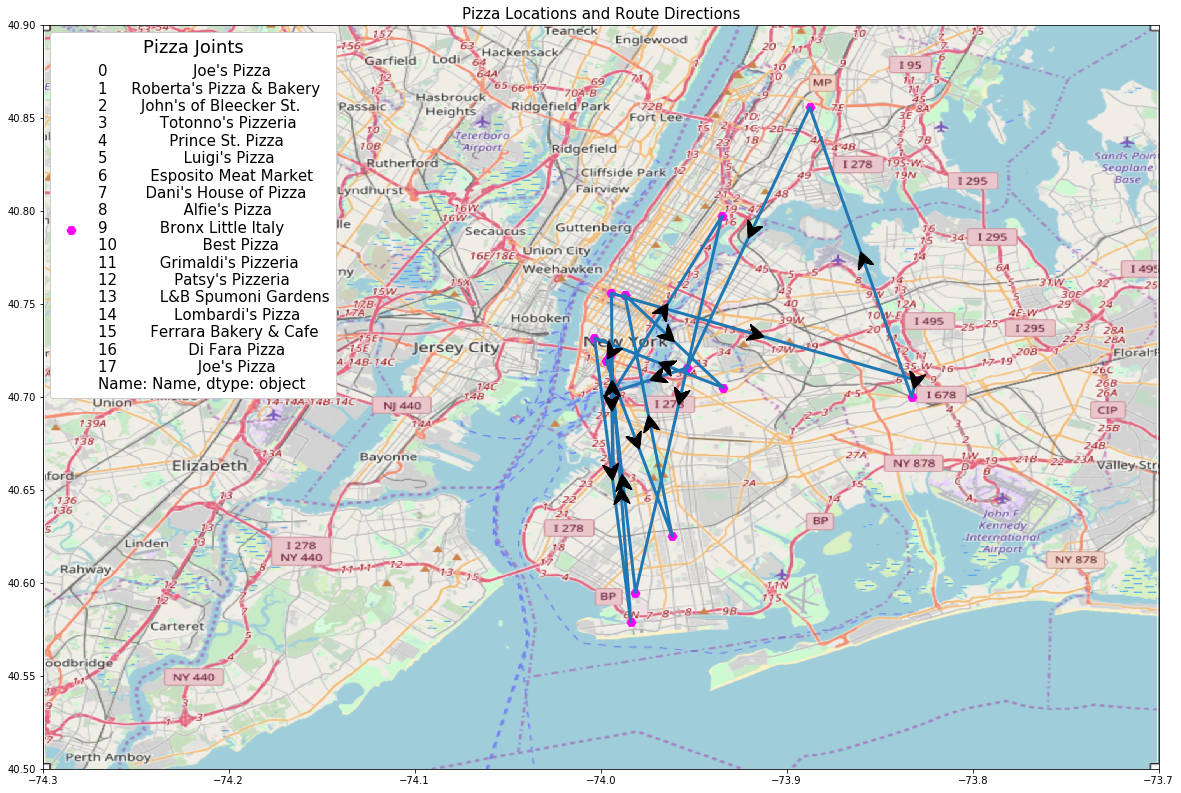

In [20]:
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
plot_on_map(points, BB_zoom, nyc_map_loc, s=20, alpha=0.3)

In [21]:
# minimum and maximum longitude test set
min(points.Longitude.min(), points.Longitude.min()), \
max(points.Longitude.max(), points.Longitude.max())

(-74.00335, -73.83053000000002)

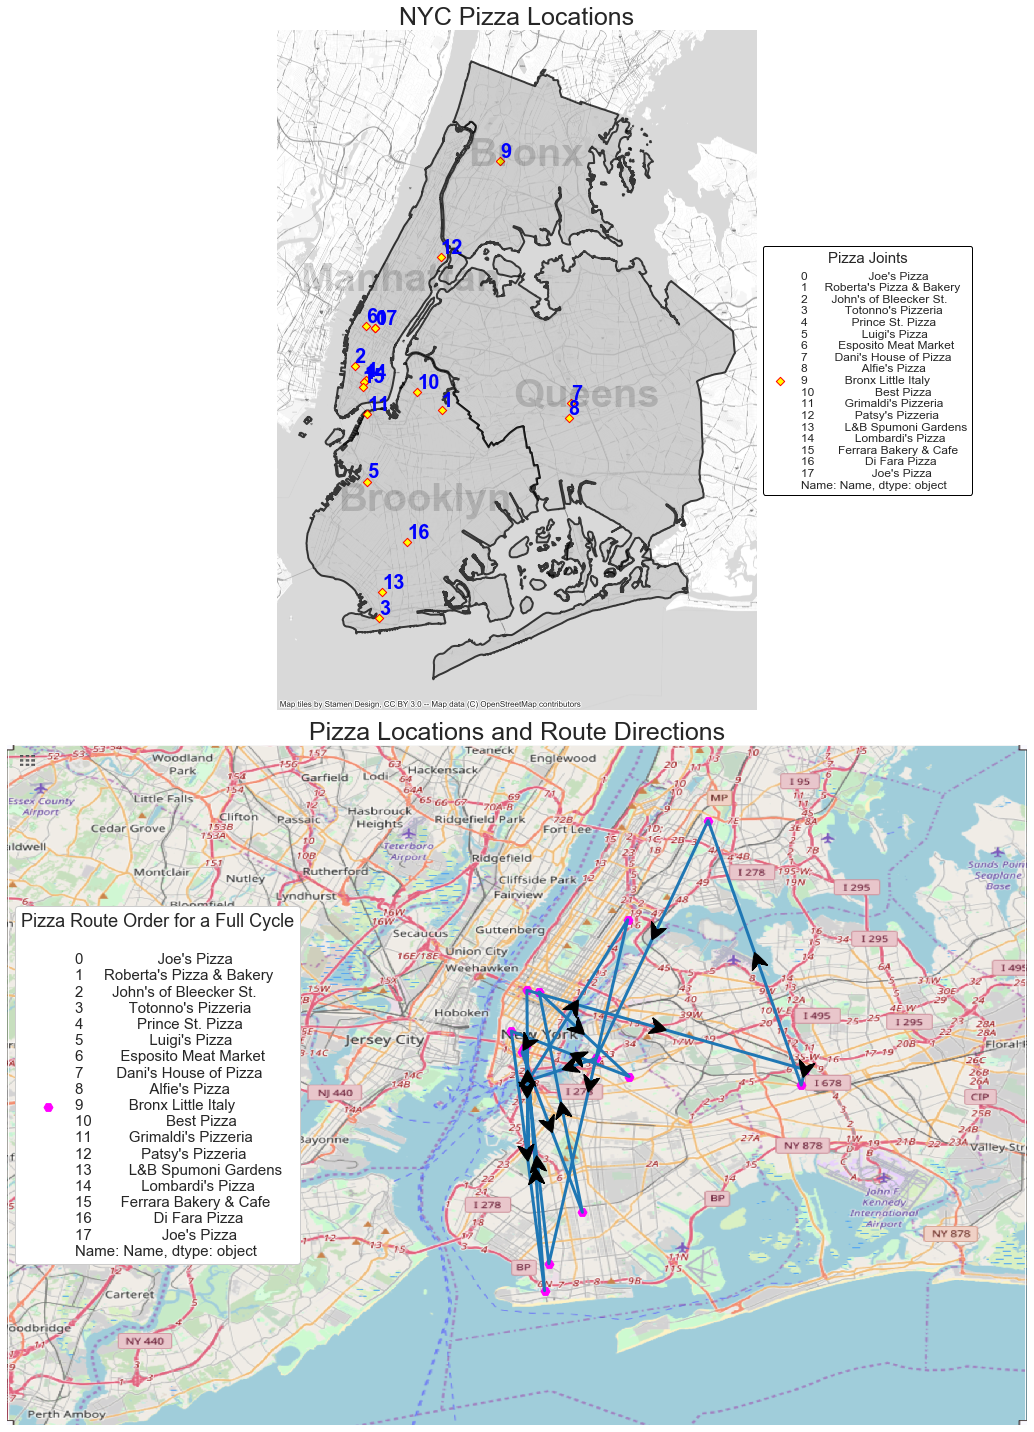

In [73]:
# SINCE THESE 2 GRAPHICS MUST BE PROJECTED DIFFERENTLY DUE TO USING TILES, I MUST SPLIT THEM UP. 
#I WANTED TO OVERLAY BUT NO DICE. SO HERE THEY ARE SUBPLOTTED BY ROW
############### 1
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
plt.style.use('seaborn-white')
ax1 = dfNY.plot(ax=ax1, alpha=0.75, edgecolor='k', facecolor = 'silver',linewidth=2)
dfNY.apply(lambda x: ax1.annotate(s=x.BoroName, xy=x.geometry.centroid.coords[0], size=40,c='black',alpha=0.15,ha='center', weight='bold'),axis=1)
points.plot(ax=ax1, marker="D", markersize=35,  edgecolor='red',color='yellow', label=points['Name']) 

points.apply(lambda x: ax1.annotate(s=x.ID, xy=x.geometry.centroid.coords[0],size=20,ha='left',va="bottom",c='b',weight='bold',alpha=1),axis=1)
ctx.add_basemap(ax1,source=ctx.providers.Stamen.TonerLite, zoom=15)

ax1.legend(title='Pizza Joints', loc='center left', bbox_to_anchor=(1, 0.5),frameon=True,framealpha=1,facecolor='white',fontsize=12,title_fontsize=15, fancybox=True,edgecolor = 'k')
ax1.set_title("NYC Pizza Locations", fontsize=25)
ax1.set_axis_off()
#plt.savefig('Pizza_labels2.png')#,bbox_inches='tight');
#scale_bar = ScaleBar(meter_per_px_adjusted, units="m", location=kwargs.get("location", "lower left"))

############## 2
#fig,ax=plt.subplots(1,2,2, figsize=(10,10))#, dpi=100)
x = points['Longitude']
y = points['Latitude']
# calculate position and direction vectors:
x0 = x.iloc[range(len(x)-1)].values
x1 = x.iloc[range(1,len(x))].values
y0 = y.iloc[range(len(y)-1)].values
y1 = y.iloc[range(1,len(y))].values
xpos = (x0+x1)/2
ypos = (y0+y1)/2
xdir = x1-x0
ydir = y1-y0
# plot map
ax2.scatter(x,y, marker='H',c='fuchsia',s=80,label=points["Name"])
BB = (-74.3, -73.7, 40.5, 40.9)
nyc_map = plt.imread('nyc_-74.3_-73.7_40.5_40.9.png')
ax2.set_xlim((BB[0], BB[1]))
ax2.set_ylim((BB[2], BB[3]))
ax2.set_title('Pizza Locations and Route Directions', fontsize=25)
ax2.imshow(nyc_map, zorder=0, extent=BB)
ax2.set_axis_off()
ax2.plot(x,y,linewidth=3)
ax2.legend(loc=6,title='Pizza Route Order for a Full Cycle', labelspacing=1.5,
           frameon=True,facecolor='white', framealpha=1,fontsize=15,title_fontsize=18)
# plot arrow on each line:
for X,Y,dX,dY in zip(xpos, ypos, xdir, ydir):
    ax2.annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
    arrowprops=dict(arrowstyle='fancy',color='k'), size = 40)

    
plt.tight_layout()
plt.savefig('../data/Pizza_shabang.png', dpi=1000)#,bbox_inches='tight');


In [4]:
df = pd.read_csv("../data/ALL_Restaurant_Subway_Locations.csv")#,index_col=0)
df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1, inplace=True)

/Users/RoscoeBColtrane/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(383402, 13)


Longitude          Latitude                            Name  \
0      -73.902168   40.868621049983            MONTEZUMA RESTAURANT   
1      -73.974161   40.753163665912                 RESTAURANT RIKI   
2      -73.994406   40.614953348362               WASABI RESTAURANT   
3      -73.918465   40.615278533753                       CHINA WOK   
4      -73.859395   40.708623411036  EDDY'S FRESH BREAKFAST & LUNCH   
...           ...               ...                             ...   
383397 -73.981236  40.5772810000675     Coney Island - Stillwell Av   
383398 -74.002197   40.755446359616          34th St - Hudson Yards   
383399 -73.958362   40.768802510149                         72nd St   
383400 -73.951771  40.7778610433316                         86th St   
383401 -73.947066  40.7842366501777                         96th St   

             BORO BUILDING                 STREET ZIPCODE CUISINE DESCRIPTION  \
0           Bronx      119  WEST KINGSBRIDGE ROAD   10468             Mexican   
1       Manhattan      141       EAST   45 STREET   10017            Japanese   
2        Brooklyn     7222              18 AVENUE   11204            Japanese   
3        Brooklyn     5813               AVENUE T   11234             Chinese   
4          Queens     7509         WOODHAVEN BLVD   11385            American   
...           ...      ...                    ...     ...                 ...   
383397        NaN      NaN                    NaN     NaN                 NaN   
383398        NaN      NaN                    NaN     NaN                 NaN   
383399        NaN      NaN                    NaN     NaN                 NaN   
383400        NaN      NaN                    NaN     NaN                 NaN   
383401        NaN      NaN                    NaN     NaN                 NaN   

              TYPE                                URL         LINE  \
0       restaurant                                NaN          NaN   
1       restaurant                                NaN          NaN   
2       restaurant                                NaN          NaN   
3       restaurant                                NaN          NaN   
4       restaurant                                NaN          NaN   
...            ...                                ...          ...   
383397      subway  http://web.mta.info/nyct/service/      D-F-N-Q   
383398      subway  http://web.mta.info/nyct/service/  7-7 Express   
383399      subway  http://web.mta.info/nyct/service/            Q   
383400      subway  http://web.mta.info/nyct/service/            Q   
383401      subway  http://web.mta.info/nyct/service/            Q   

                                                 Comments  \
0                                                     NaN   
1                                                     NaN   
2                                                     NaN   
3                                                     NaN   
4                                                     NaN   
...                                                   ...   
383397                                  D,F,N,Q-all times   
383398  7-all times, 7 Express-rush hours AM westbound...   
383399                                        Q-all times   
383400                                        Q-all times   
383401                                        Q-all times   

                                      coords  
0                                        NaN  
1                                        NaN  
2                                        NaN  
3                                        NaN  
4                                        NaN  
...                                      ...  
383397   -73.9812359981396 40.57728100006751  
383398  -74.00219709442206 40.75544635961596  
383399  -73.95836178682246 40.76880251014895  
383400  -73.95177090964917 40.77786104333163  
383401  -73.9470660219183 40.784236650177654  

[383402 rows x 13 columns]

In [9]:
# CHECK TO MAKE SURE OUR LAT LONG ARE FLOATS
df['Latitude']=df['Latitude'].apply(pd.to_numeric, downcast='float', errors='coerce')
df.dtypes

Longitude              float64
Latitude               float64
Name                    object
BORO                    object
BUILDING                object
STREET                  object
ZIPCODE                 object
CUISINE DESCRIPTION     object
TYPE                    object
URL                     object
LINE                    object
Comments                object
coords                  object
dtype: object

In [5]:
#  read in NYC and boroughs
dfNY = gpd.read_file(gpd.datasets.get_path('nybb'))
#ax = dfNY.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
dfNY['geometry']
dfNY.crs

dfNY = dfNY.to_crs("EPSG:4326")
# Exclude Staten Island for now
# ### if needed ####   SET AXIS BOUNDING BOX LIMITS
x0, y0, x1, y1 = dfNY.geometry.total_bounds
dfNY = dfNY[dfNY['BoroName'].isin(['Staten Island']) == False]


/Users/RoscoeBColtrane/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


Text(0.5, 1, 'All NYC Restaurants Mapped as Points over 4 Boroughs')

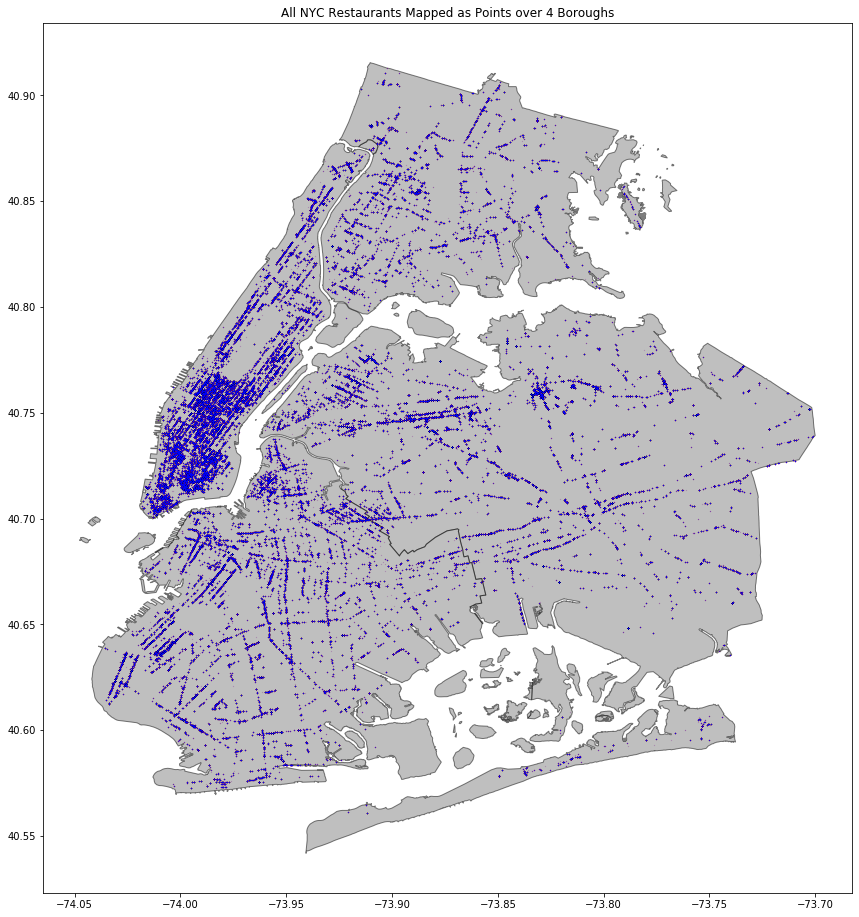

In [12]:
# this function will also be used with the test set below
%time
def select_within_boundingbox(df, BB):
    return (df.Longitude >= BB[0]) & (df.Longitude <= BB[1]) & \
           (df.Latitude >= BB[2]) & (df.Latitude <= BB[3]) 

fig, ax = plt.subplots(1, 1, figsize=(20,16))
dfNY.plot(ax=ax,alpha=0.5, edgecolor='k',facecolor='gray' )

ax.scatter(df.Longitude, df.Latitude, c='r', s=0.01, alpha=0.5)
ax.scatter(df.Longitude, df.Latitude, c='b', s=0.01, alpha=0.5)
ax.set_title("All NYC Restaurants Mapped as Points over 4 Boroughs")
#ax.set(xlim=(x0, x1), ylim=(y0, y1))

# AND LASTLY, LET'S HAVE SOME 'ZA !

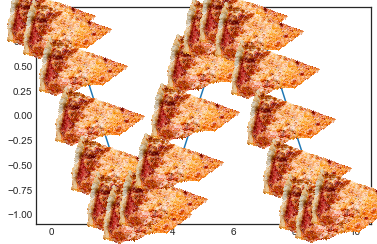

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

def main():
    x = np.linspace(0, 10, 20)
    y = np.cos(x)
    image_path = '../data/za.png'
    fig, ax = plt.subplots()
    imscatter(x, y, image_path, zoom=0.1, ax=ax)
    ax.plot(x, y)
    plt.show()
    #plt.savefig('Pizza_Sign.png')

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    plt.savefig('../results/Pizza_Sign.png')
    return artists
    
main()
    
